In [1]:
# fix imports
from fix_imports import fix_relative_imports
fix_relative_imports()

In [2]:
from gan_network.generator import Generator
from gan_network.pix2pix_data_pipeline import get_test_dataset
import tensorflow as tf

## Plotting Generator

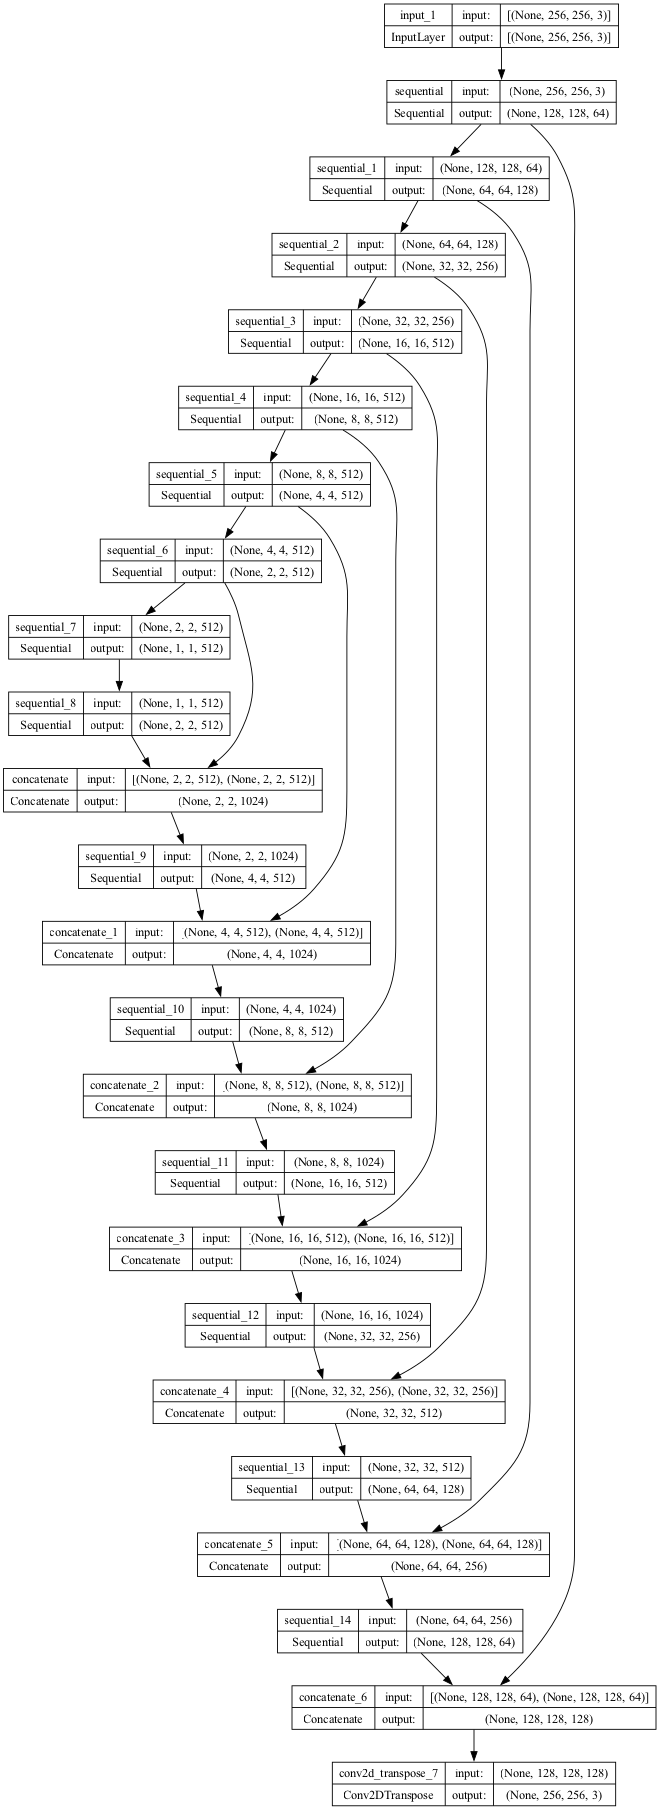

In [3]:
generator = Generator()
tf.keras.utils.plot_model(generator, to_file='generator.png', show_shapes=True, dpi=64)

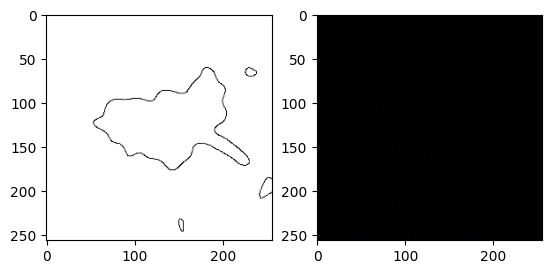

In [4]:
# test generator

from matplotlib import pyplot as plt


test_data = get_test_dataset("../data/saved_input_data")
# get only one input image from batch dataset

inp = next(iter(test_data)).input_image[0]
gen_output = generator(inp[tf.newaxis, ...], training=False)

# print input and output images
plt.subplot(1, 2, 1)
plt.imshow(inp)
plt.subplot(1, 2, 2)

plt.imshow(gen_output[0, ...])

## Plotting Discriminator

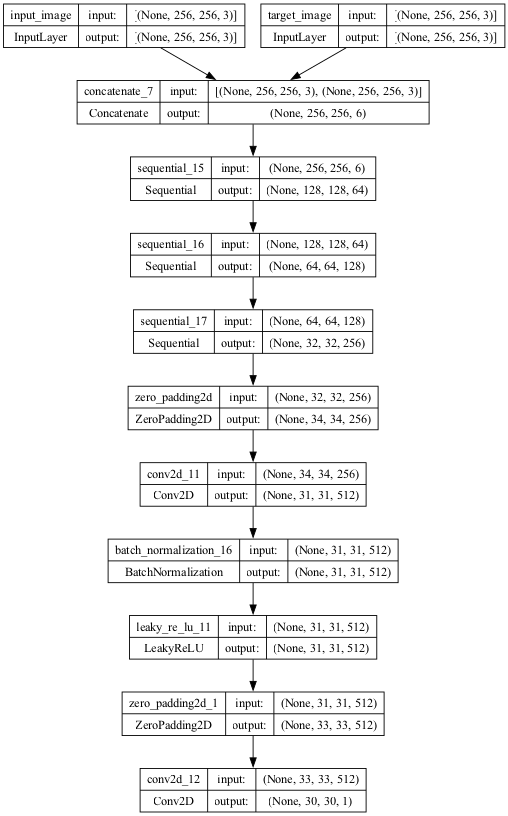

In [5]:
from gan_network.discriminator import Discriminator

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, to_file='discriminator.png', show_shapes=True, dpi=64)

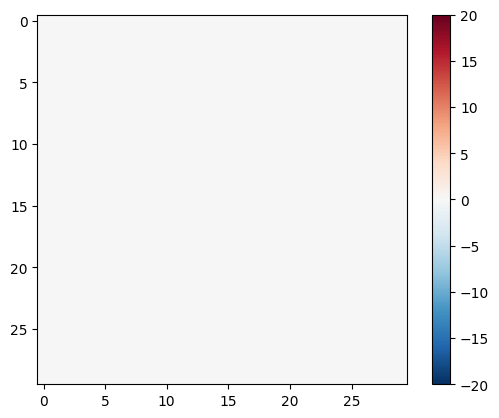

In [6]:
# test discriminator

disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.figure()
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


## Testing Model

In [8]:
from gan_network.gan_model import GanModel
CHKPT_DIR = "../data/checkpoints"
LOG_DIR = "../data/logs"
GENERATED_IMGS_DIR = "../data/generated_images"

gan_model = GanModel(
    checkpoint_dir=CHKPT_DIR,
    save_image_dir=GENERATED_IMGS_DIR,
    log_dir=LOG_DIR,  
)

### Test Image Generation

In [11]:
test_data = get_test_dataset("../data/saved_input_data")
# get only one input image from batch dataset

input_image, image  = next(iter(test_data))

gan_model.generate_images(input_image[0][tf.newaxis, ...], image[0][tf.newaxis, ...], "test_image.png")